In [43]:
import numpy as np 
from matplotlib import pyplot as plt 
import math
import os

In [44]:
class PGMImage:
    def __init__(self, file_path=None):
        self.magic_number = None
        self.width = 0
        self.height = 0
        self.maxval = 0
        self.pixels = []
        self.pixels_2d = [[]]

        if file_path:
            self.mypgmread(file_path)
            self.pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))


    def mypgmread(self, file_path):
        with open(file_path, 'rb') as file:
            self.magic_number = file.readline().strip().decode('ascii')

            line = file.readline().strip()
            while line.startswith(b'#'): 
                line = file.readline().strip()

            self.width, self.height = map(int, line.split())
            self.maxval = int(file.readline().strip())
            data = file.read()
            self.pixels = list(data)

    def modify_pixels(self, row_start, row_end, new_value):
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        pixels_2d[row_start:row_end, :] = new_value
        self.pixels = pixels_2d.flatten().tolist()

    def mypgmwrite(self, filename):
        pixel_array = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))

        with open(filename, 'wb') as file:
            file.write(f"{self.magic_number}\n".encode())
            file.write(f"{self.width} {self.height}\n".encode())
            file.write(f"{self.maxval}\n".encode())
            pixel_array.tofile(file)


####################################################################################################################################################
############################## LAB-03 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    # 2D Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Dfft(self, image=None):
        if image is None:
            image = self.pixels_2d  # Varsayılan olarak sınıfın görüntüsünü kullanır
        
        # Giriş görüntüsünün boyutlarını al
        height, width = image.shape
        
        # Fourier Dönüşümü sonucunu tutacak karmaşık (complex) dizi oluştur
        fourier_array = np.zeros((height, width), dtype=complex)
        
        # Satır bazında 1D FFT uygulanır
        for i in range(height):
            fourier_array[i] = np.fft.fft(image[i])
        
        # Sütun bazında 1D FFT uygulanır
        for k in range(width):
            fourier_array[:, k] = np.fft.fft(fourier_array[:, k])
        
        return fourier_array

# Ortalanmış Fourier dönüşüm maskesi uygulayan fonksiyon
    def centered_fourier(self):
        centered_mask = np.zeros((self.height, self.width), dtype=complex)
        for x in range(0 , self.height):
            for y in range(0 , self.width):
                centered_mask[x][y] = (-1)**(x + y)

        return centered_mask * self.pixels_2d


# 2D Ters Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Difft(self, image = None):
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass    
        
        conj_input = np.conj(image)     # Giriş görüntüsünün konjugesini al
        conj_output = self.my2Dfft(conj_input) # konjugesi alınmış görüntünün fourier transformunu al
        inverse_conj_output = conj_output / (self.height * self.width) # Çıktıyı satır*sütun değerine böl
        inverse_image = np.conj(inverse_conj_output) # çıkış değerinin de konjugesi alınır ve original image elde edilir.

        return inverse_image

500 800
3 3
800 500
[[ 0.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


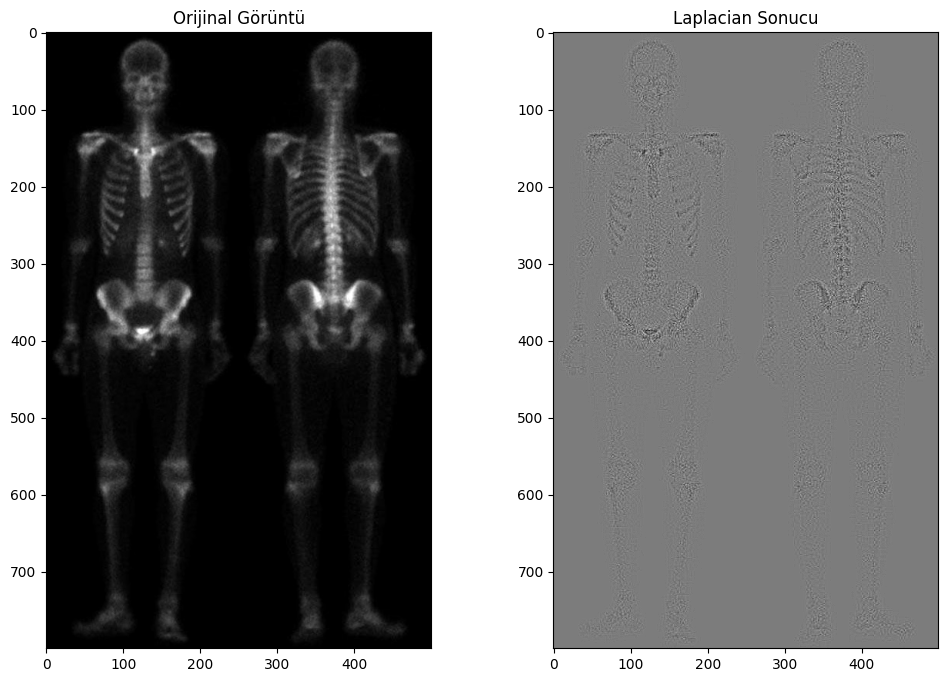

In [ ]:
image = PGMImage('Fig0343(a)(skeleton_orig).pgm')
kernel = np.array([[0, 1, 0], 
                   [1, -4, 1], 
                   [0, 1, 0]])

        
image.width
image.height 
MK, NK = kernel.shape

print(image.height, image.width)
print(MK, NK)

pad_shape = (image.height , image.width )
kernel_padded = np.zeros(pad_shape)
kernel_padded[:MK, :NK] = kernel

MK1, NK1 = kernel_padded.shape
print(MK1, NK1)
print(kernel_padded)

F_image = image.my2Dfft()
F_kernel = image.my2Dfft(kernel_padded)

# Kernel ve Görüntü'nün frekans alanındaki çarpımı
F_result = F_image * F_kernel

# Ters Fourier dönüşümü ile sonuç görüntüsünü elde et
result = image.my2Difft(F_result)
result_real = np.real(result)

# Sonuçları görselleştirme
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title("Orijinal Görüntü")
plt.imshow(image.pixels_2d, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Laplacian Sonucu")
plt.imshow(result_real, cmap="gray")

plt.show()
